In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import sys
import os
sys.path.append('../')

from transformer import create_model
from tensorflow import keras
from tensorflow.keras import layers
from utils import get_imgs_labels_paths, read_imgs_labels, create_train_dataset, show_img
from losses import bce_dice_loss
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import regularizers


In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Variables

In [3]:
dataset_path = '/storage/ziaeea21/projects/Prostate_Segmentation/data/Dataset'
checkpoint_dir = './training_checkpoints'
log_dir = "./logs/"

num_neurons = 256
num_hidden_neurons = num_neurons * 2 

resize_shape = (384 , 384)# to resize all images and labels of the dataset by reading
input_shape = (256, 256,3) # network input
output_shape = ( 256, 256,5)
num_classes = output_shape[2]

patch_size = 16 #ize of the patches to be extract from the input images
num_patches = (input_shape[0]  // patch_size) ** 2
num_heads = 4 # num_neurons // num_heads shoul be 2

num_enc_layers = 3
num_maskTransformer_layers = 3

batch_size = 64
buffer_size = 400
epochs = 1000
number_images = 719
steps = number_images//batch_size

In [4]:
imgs_labels_paths = get_imgs_labels_paths(dataset_path)
x_train, y_train = read_imgs_labels(imgs_labels_paths, resize_shape, num_classes)
print(x_train.shape, y_train.shape)
train_dataset = create_train_dataset(x_train, y_train, buffer_size, batch_size, input_shape[:2] )

(719, 384, 384, 3) (719, 384, 384, 5)


In [5]:
tf.config.run_functions_eagerly(True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 256, 256, 3) (64, 256, 256, 5)
Unique numbers in channel 0 are 0.0,1.0
Unique numbers in channel 1 are 0.0,1.0
Unique numbers in channel 2 are 0.0,1.0
Unique numbers in channel 3 are 0.0,0.0
Unique numbers in channel 4 are 0.0,1.0


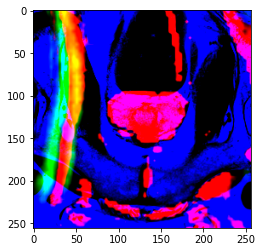

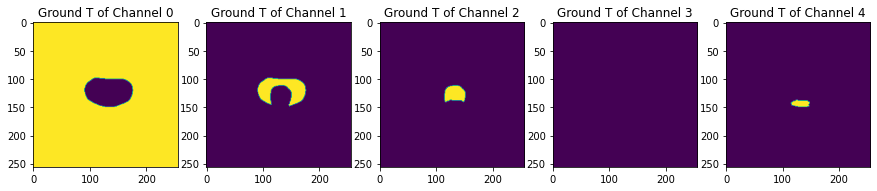

In [6]:
for example_input, example_target in train_dataset.take(1):
    print(example_input.shape, example_target.shape)
    show_img(example_input, example_target, 5)

# Model

In [7]:
model = create_model(input_shape, num_patches, patch_size, num_neurons,
                     num_hidden_neurons, num_heads, num_classes, 
                     num_enc_layers, num_maskTransformer_layers)

Encoder Input Shape : (None, 256, 256, 3)
Patches Shape:  (None, 256, 768)
Patch encoder Shape:  (None, 256, 256)
Encoder output Shape:  (None, 256, 256)
z, c output Shape:  (None, 256, 256) (None, 5, 256)
Masks output Shapes:  (None, 256, 5)
Upsapled masks output Shape:  (None, 256, 256, 5)


In [8]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
patches (Patches)               (None, 256, 768)     0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 256, 256)     262400      patches[0][0]                    
__________________________________________________________________________________________________
encoder (Encoder)               (None, 256, 256)     4141824     patch_encoder[0][0]              
______________________________________________________________________________________________

print([weight.name for weight in model.weights])

In [9]:
listWeights= ['encoder/transformer_layer/multi_head_attention_layer/multi_head_attention/attention_output/kernel:0',
'encoder/transformer_layer_1/multi_head_attention_layer_1/multi_head_attention_1/attention_output/kernel:0', 
'encoder/transformer_layer_2/multi_head_attention_layer_2/multi_head_attention_2/attention_output/kernel:0',
'mask_transformer/transformer_layer_3/multi_head_attention_layer_3/multi_head_attention_3/attention_output/kernel:0',
'mask_transformer/transformer_layer_4/multi_head_attention_layer_4/multi_head_attention_4/attention_output/kernel:0',
'mask_transformer/transformer_layer_5/multi_head_attention_layer_5/multi_head_attention_5/attention_output/kernel:0']
listVariable=['Variable:0']*6
#print([weight.name for weight in model.weights])

In [10]:
for weight in model.weights:
    if weight.name in listWeights:
        print(tf.reduce_sum(weight,[0,1,2] ))
    if  weight.name in listVariable:
        print(weight)

tf.Tensor(11.926955, shape=(), dtype=float32)
tf.Tensor(-6.5181656, shape=(), dtype=float32)
tf.Tensor(-35.627293, shape=(), dtype=float32)
tf.Tensor(-25.813374, shape=(), dtype=float32)
tf.Tensor(-22.913975, shape=(), dtype=float32)
tf.Tensor(11.550231, shape=(), dtype=float32)


tf.Tensor(238.3553, shape=(), dtype=float32)
tf.Tensor(222.83627, shape=(), dtype=float32)
tf.Tensor(-1019.9587, shape=(), dtype=float32)
tf.Tensor(279.17264, shape=(), dtype=float32)
tf.Tensor(-896.53314, shape=(), dtype=float32)
tf.Tensor(-248.9895, shape=(), dtype=float32)

In [11]:
initial_learning_rate = 1e-2

def learning_rate_fn(epoch, n_epochs):
    k = initial_learning_rate
    return k * (1-(epoch/n_epochs))


model_optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate,
                                           beta_1=0.9,
                                           beta_2=0.999,
                                           )#clipvalue=1.0


In [12]:
checkpoint_dir = './training_checkpoints'
log_dir="logs/"

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(model_optimizer = model_optimizer, model=model)

summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [13]:
@tf.function
def train_step(input_image, target, epoch, n):
    with tf.GradientTape() as model_tape:
        
        model_output = model(input_image)
        total_loss = bce_dice_loss(target, model_output, num_classes)
        if (n + 1) % 2 == 0:
            tf.print('bce_dice_loss',n, total_loss)

    model_gradients = model_tape.gradient(total_loss,
                                         model.trainable_variables)
    
    model_gradients, _ = tf.clip_by_global_norm(model_gradients, 5.0)

    model_optimizer.apply_gradients(zip(model_gradients,  model.trainable_variables))

    
    with summary_writer.as_default():
        tf.summary.scalar('bce_dice_loss', total_loss, step=epoch)
        tf.summary.scalar('learning_rate', model_optimizer.lr.numpy(), step=epoch)


In [14]:
mIoU = tf.keras.metrics.MeanIoU(num_classes=num_classes)

In [15]:
@tf.function
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
            model_output = model(example_input)
            print(example_input.shape, example_target.shape, model_output.shape)
            #mIoU.update_state(model_output, example_target)
            tf.print('iou_coef_keras', mIoU.result().numpy())
            plot_images( example_input, example_target, model_output, num_classes)
            
        print("Epoch: ", epoch)


        # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) <= steps:
                train_step(input_image, target, epoch, n)
            

        # Save (checkpoint) the model every 2 steps
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    
        #new_learning_rate = learning_rate_fn(epoch, epochs) 
        #model_optimizer.lr.assign(new_learning_rate)

        print('learning_rate', model_optimizer.lr.numpy())


In [16]:
def plot_images(SB, GT, prediction, num_classes):
    
    plt.figure(figsize=(4,4))
    plt.imshow(SB[0])
    plt.show()

    plt.figure(figsize=(15,15))
    for i in range(num_classes):
        plt.subplot(1, num_classes, i+1)
        plt.title('G'+str(i))
        plt.imshow(GT[0,:,:,i]*.5+.5 )
        plt.axis('off')
    plt.show()

    plt.figure(figsize=(15,15))
    for i in range(num_classes):
        plt.subplot(1, num_classes, i+1)
        plt.title('P'+str(i))
        plt.imshow(prediction[0,:,:,i]*.5+.5 )
        plt.axis('off')
    plt.show()


    print('**********************************************************')

In [17]:
fit(train_dataset,2000, train_dataset)#1.66838455

KeyboardInterrupt: 

(64, 256, 256, 3) (64, 256, 256, 5) (64, 256, 256, 5)
iou_coef_keras 0.9218812


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


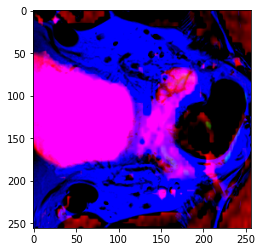

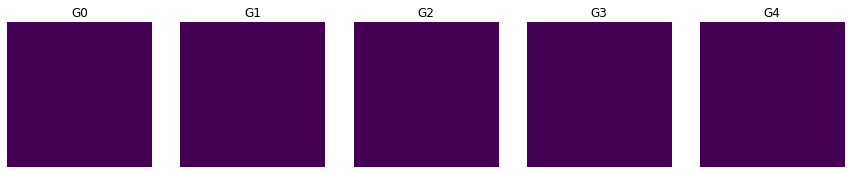

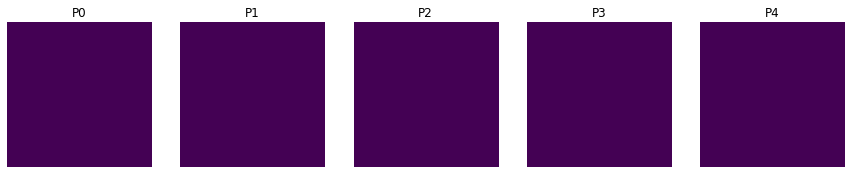

**********************************************************
(64, 256, 256, 3) (64, 256, 256, 5) (64, 256, 256, 5)
iou_coef_keras 0.9140099


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


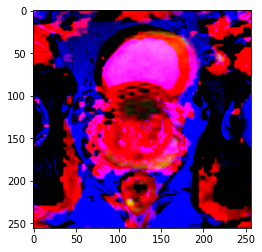

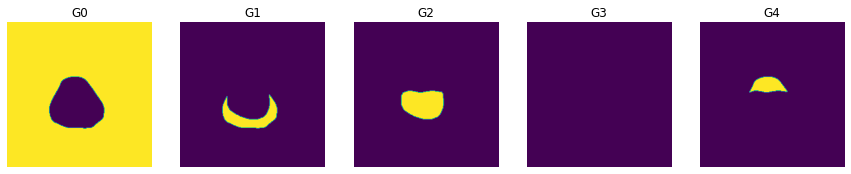

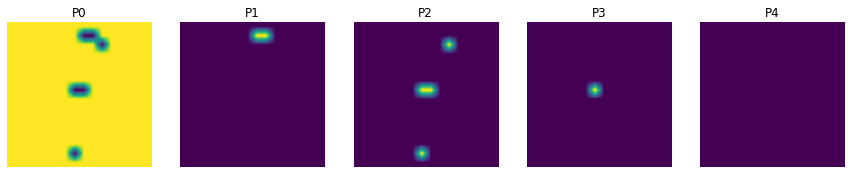

**********************************************************
(64, 256, 256, 3) (64, 256, 256, 5) (64, 256, 256, 5)
iou_coef_keras 0.9116685


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


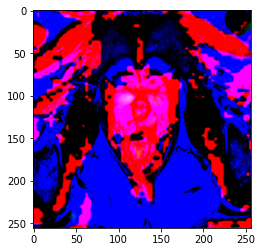

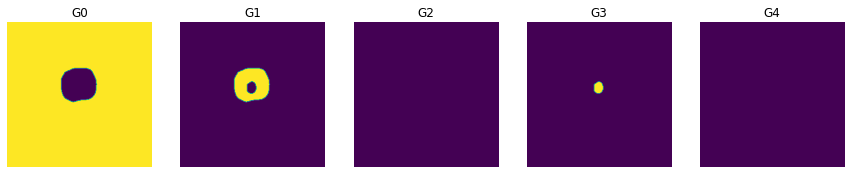

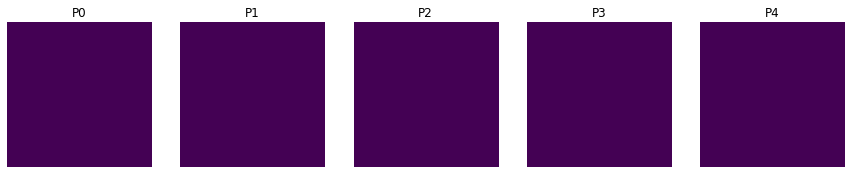

**********************************************************
(64, 256, 256, 3) (64, 256, 256, 5) (64, 256, 256, 5)
iou_coef_keras 0.91097665


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


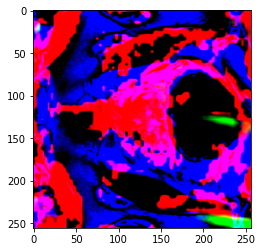

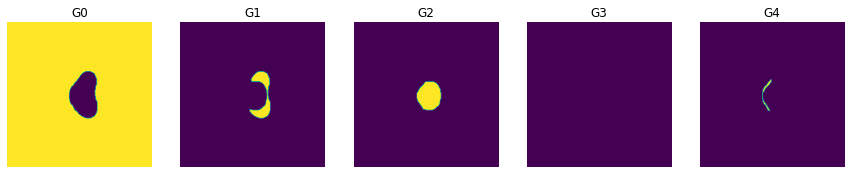

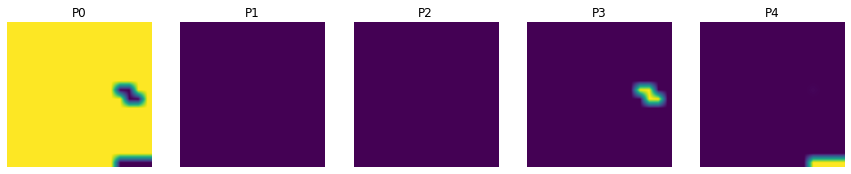

**********************************************************
(64, 256, 256, 3) (64, 256, 256, 5) (64, 256, 256, 5)
iou_coef_keras 0.9083353


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


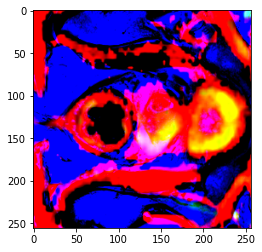

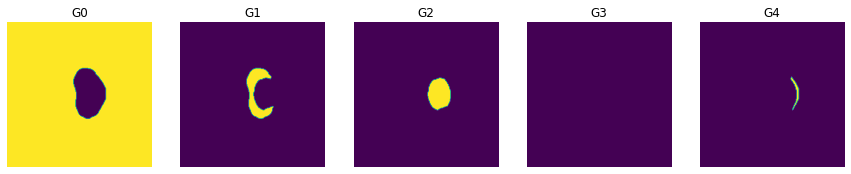

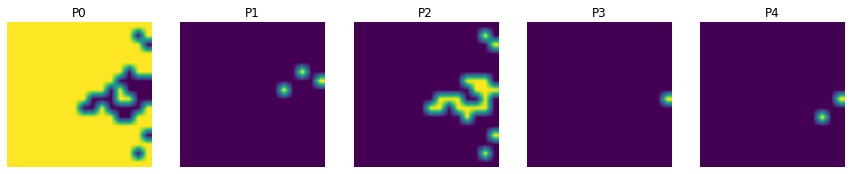

**********************************************************
(64, 256, 256, 3) (64, 256, 256, 5) (64, 256, 256, 5)
iou_coef_keras 0.90919363


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


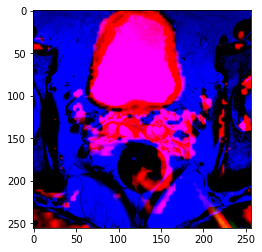

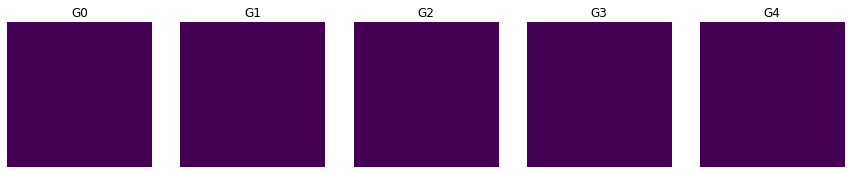

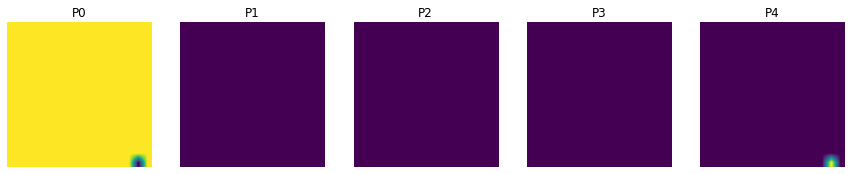

**********************************************************
(64, 256, 256, 3) (64, 256, 256, 5) (64, 256, 256, 5)
iou_coef_keras 0.90945256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


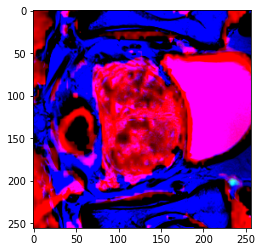

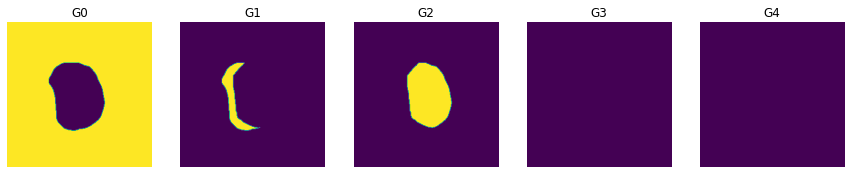

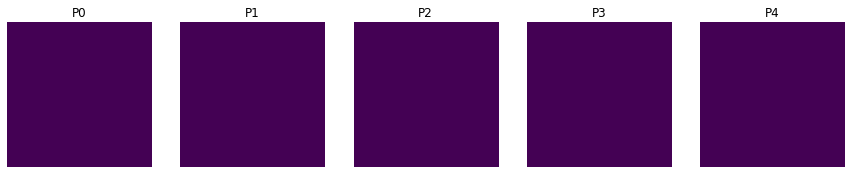

**********************************************************
(64, 256, 256, 3) (64, 256, 256, 5) (64, 256, 256, 5)
iou_coef_keras 0.9086901


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


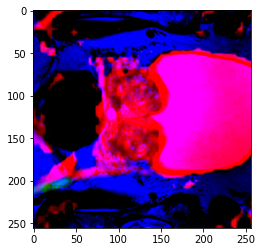

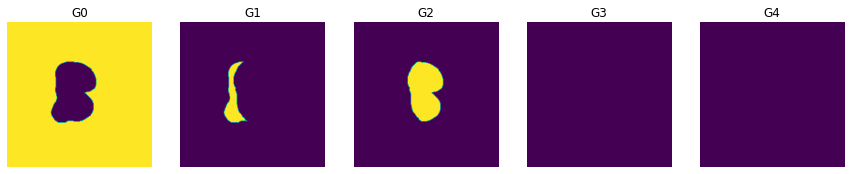

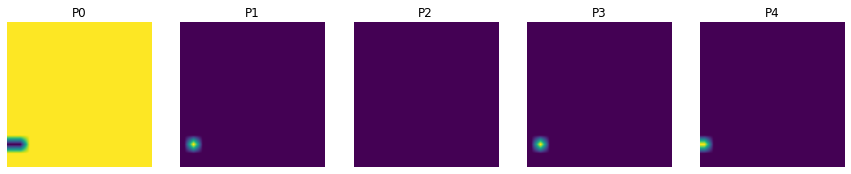

**********************************************************
(64, 256, 256, 3) (64, 256, 256, 5) (64, 256, 256, 5)
iou_coef_keras 0.9092514


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


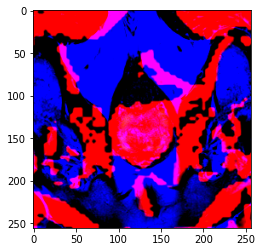

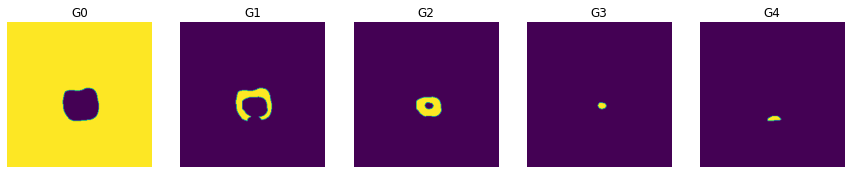

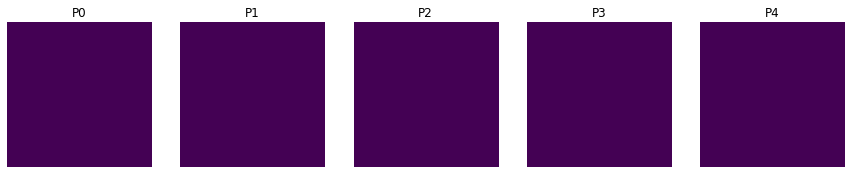

**********************************************************
(64, 256, 256, 3) (64, 256, 256, 5) (64, 256, 256, 5)
iou_coef_keras 0.9103588


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


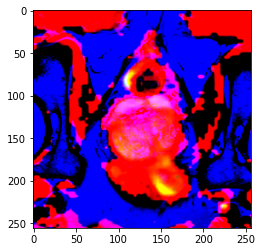

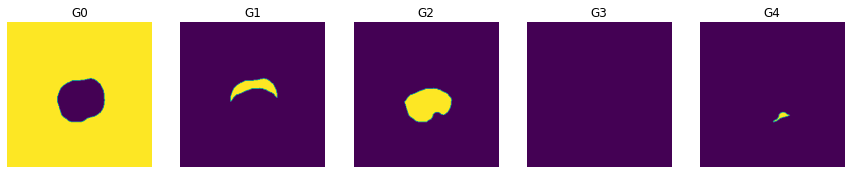

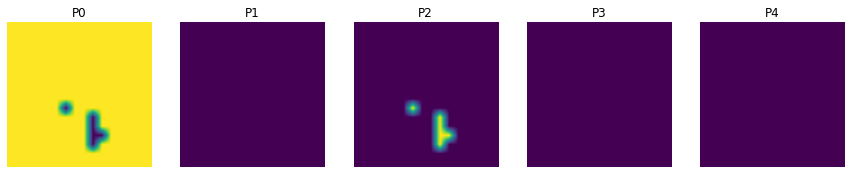

**********************************************************


In [18]:
for example_input, example_target in train_dataset.take(10):
    model_output = model(example_input)
    print(example_input.shape, example_target.shape, model_output.shape)
    mIoU.update_state(model_output, example_target)
    tf.print('iou_coef_keras', mIoU.result().numpy())
    plot_images( example_input, example_target, model_output, num_classes)


In [ ]:
inputs = tf.random.uniform((4,256,256))
from tensorflow.keras import backend as K


In [ ]:
mean = K.mean(inputs, axis=[0], keepdims=False)
variance = K.mean(K.square(inputs - mean), axis=[0], keepdims=False)
std = K.sqrt(variance + .0001)
outputs = (inputs - mean) / std
mean_coeff  = K.mean(outputs, axis=[0,1,2], keepdims=False)


In [ ]:
beta = tf.random.uniform((256,))

In [ ]:
output  =  ((mean_coeff * inputs)  + beta) * inputs

In [ ]:
mean_coeff